Found 8863 images belonging to 2 classes.
Found 600 images belonging to 2 classes.
class_indices: {'not fractured': 0, 'fractured': 1}
Saved class_indices.json
Epoch 1/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 79s 282ms/step - accuracy: 0.5715 - loss: 0.6690 - val_accuracy: 0.5650 - val_loss: 0.6686
Epoch 2/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 70s 253ms/step - accuracy: 0.6324 - loss: 0.6283 - val_accuracy: 0.6383 - val_loss: 0.5787
Epoch 3/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 73s 264ms/step - accuracy: 0.7077 - loss: 0.5673 - val_accuracy: 0.7300 - val_loss: 0.5300
Epoch 4/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 77s 276ms/step - accuracy: 0.7498 - loss: 0.4976 - val_accuracy: 0.6483 - val_loss: 0.6177
Epoch 5/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 825s 3s/step - accuracy: 0.7995 - loss: 0.4325 - val_accuracy: 0.6283 - val_loss: 0.5595
Epoch 6/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 67s 241ms/step - accuracy: 0.8278 - loss: 0.3825 - val_accuracy: 0.7283 - val_loss: 0.4968
Epoch 7/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 63s 229ms/step -

Saved Keras model to fracture_detection_model.h5
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step
Confusion Matrix:
[[ 56 184]
 [ 51 309]]

Classification Report:
               precision    recall  f1-score   support

not fractured     0.5234    0.2333    0.3228       240
    fractured     0.6268    0.8583    0.7245       360

     accuracy                         0.6083       600
    macro avg     0.5751    0.5458    0.5236       600
 weighted avg     0.5854    0.6083    0.5638       600



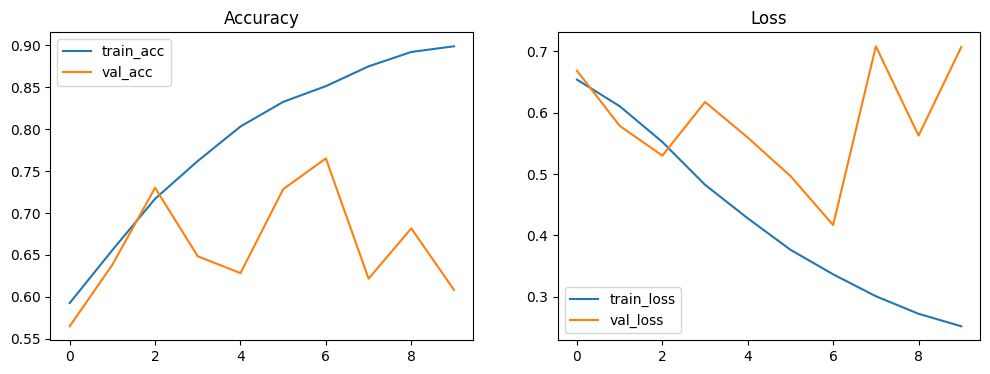

INFO:tensorflow:Assets written to: C:\Users\HP\AppData\Local\Temp\tmpvyhwwuo8\assets


INFO:tensorflow:Assets written to: C:\Users\HP\AppData\Local\Temp\tmpvyhwwuo8\assets


Saved artifact at 'C:\Users\HP\AppData\Local\Temp\tmpvyhwwuo8'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name='input_layer_2')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  1568375238352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1568375239312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1568375240080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1568375239504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1568375239696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1568375240464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1568375238928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1568375240848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1568375239120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1568375241040: TensorSpec(shape=(), dtype=tf.resource, name=None)
Saved mod

c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflow\lite\python\interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


In [ ]:
# CNN.ipynb 
import os
import json
import numpy as np
import matplotlib.pyplot as plt

# Use keras imports to avoid Pylance false positives in VS Code.
# If runtime complains, switch to `from tensorflow.keras...` instead.
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # type: ignore
from tensorflow.keras.models import Sequential   # type: ignore
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout # type: ignore
from tensorflow.keras.optimizers import Adam  # type: ignore
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True


# For conversion and safe loading/saving, we also import tensorflow
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report

# --- Paths ---
train_dir = "data/train"
valid_dir = "data/val"

# sanity checks
assert os.path.exists(train_dir), f"Train directory not found: {train_dir}"
assert os.path.exists(valid_dir), f"Validation directory not found: {valid_dir}"

# --- Data generators (with augmentation for training) ---
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.05,
    horizontal_flip=True,
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(rescale=1.0/255.0)

# IMPORTANT: explicit classes order ensures index mapping is stable
# Replace these names if your folders are named differently.
classes = ['not fractured', 'fractured']

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    classes=classes,   # force mapping: index 0 -> 'no_fracture', index 1 -> 'fracture'
    shuffle=True
)

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    classes=classes,   # same mapping for validation
    shuffle=False      # IMPORTANT: keep False for correct y_true ordering
)

# Save class_indices so app and inference use same mapping
print("class_indices:", train_generator.class_indices)
class_indices = train_generator.class_indices
with open("class_indices.json", "w") as f:
    json.dump(class_indices, f)
print("Saved class_indices.json")

# --- Build CNN model (your architecture, unchanged) ---
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # binary: 0 -> no_fracture, 1 -> fracture
])

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# --- Train ---
epochs = 10
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=epochs,
    verbose=1
)

# --- Save Keras model ---
keras_model_path = "fracture_detection_model.h5"
model.save(keras_model_path)
print(f"Saved Keras model to {keras_model_path}")

# --- Evaluate on validation set with confusion matrix (verify mapping) ---
valid_generator.reset()  # ensure consistent ordering
y_true = valid_generator.classes  # works because shuffle=False
y_pred_probs = model.predict(valid_generator, verbose=1)
y_pred = (y_pred_probs.ravel() > 0.5).astype(int)

print("Confusion Matrix:")
cm = confusion_matrix(y_true, y_pred)
print(cm)
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=classes, digits=4))

# Plot training history (accuracy and loss)
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend(); plt.title('Accuracy')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(); plt.title('Loss')
plt.show()

# --- Convert to TFLite ---
# Load with tensorflow to make converter happy (works with keras saved model)
tf_model = tf.keras.models.load_model(keras_model_path)

converter = tf.lite.TFLiteConverter.from_keras_model(tf_model)
# Optional: optimizations for smaller model (uncomment if desired)
# converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()
with open("model.tflite", "wb") as f:
    f.write(tflite_model)
print("Saved model.tflite")

# --- Quick Keras vs TFLite check on a single validation file (debug) ---
from PIL import Image

# pick first validation image for a debug comparison
test_rel_path = valid_generator.filenames[0]  # relative to valid_dir
test_path = os.path.join(valid_dir, test_rel_path)
print("Debug image:", test_path)

img = Image.open(test_path).convert('RGB').resize((128,128))
x = np.array(img) / 255.0
x = np.expand_dims(x, 0).astype(np.float32)

# Keras prediction
p_keras = tf_model.predict(x).ravel()[0]

# TFLite prediction - ensure dtype matches interpreter's expected dtype
interpreter = tf.lite.Interpreter(model_path="model.tflite")
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()[0]
output_details = interpreter.get_output_details()[0]

x_tflite = x.copy()
if input_details['dtype'] == np.uint8:
    x_tflite = (x_tflite * 255).astype(np.uint8)
else:
    x_tflite = x_tflite.astype(np.float32)

interpreter.set_tensor(input_details['index'], x_tflite)
interpreter.invoke()
p_tflite = interpreter.get_tensor(output_details['index']).ravel()[0]

print(f"Keras prob: {p_keras:.6f}   TFLite prob: {p_tflite:.6f}")
print(f"True label (from valid generator): {y_true[0]}  -> class name: {classes[y_true[0]]}")
print("Pred (keras):", int(p_keras>0.5), "Pred (tflite):", int(p_tflite>0.5))


In [5]:
# Quick confusion matrix check
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# Get filenames and true labels from generator
valid_generator.reset()  # important
Y_true = valid_generator.classes  # array of true labels in the same order
# Predict probabilities
preds = model.predict(valid_generator, verbose=1)
# Convert probs -> predicted label indices (0 or 1)
Y_pred = (preds.ravel() > 0.5).astype(int)

print("Confusion Matrix:")
print(confusion_matrix(Y_true, Y_pred))
print("\nClassification Report:")
print(classification_report(Y_true, Y_pred, target_names=classes))


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step
Confusion Matrix:
[[ 56 184]
 [ 51 309]]

Classification Report:
               precision    recall  f1-score   support

not fractured       0.52      0.23      0.32       240
    fractured       0.63      0.86      0.72       360

     accuracy                           0.61       600
    macro avg       0.58      0.55      0.52       600
 weighted avg       0.59      0.61      0.56       600



In [6]:
# 1. Print class indices from your generators
print("train class_indices:", train_generator.class_indices)
print("valid class_indices:", valid_generator.class_indices)

# 2. Show first 20 filenames with their labels (validation)
valid_generator.reset()                # important
for i in range(1):                     # batch loop index 0 only
    X_batch, y_batch = next(valid_generator)
    print("y_batch (first 10):", y_batch[:10])
    break

# 3. Predict on the same validation batch using your Keras model
preds = model.predict(X_batch)         # shape (batch, 1)
probs = preds.ravel()
pred_labels = (probs > 0.5).astype(int)
print("probs (first 10):", probs[:10])
print("pred_labels (first 10):", pred_labels[:10])
print("true labels (first 10):", y_batch[:10].astype(int))

# 4. Confusion matrix on entire validation set (ensure shuffle=False in generator)
valid_generator.reset()
from sklearn.metrics import confusion_matrix, classification_report
y_true = valid_generator.classes      # only works when shuffle=False
y_pred_probs = model.predict(valid_generator)
y_pred = (y_pred_probs.ravel() > 0.5).astype(int)
print("Confusion matrix:\n", confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred, digits=4))


train class_indices: {'not fractured': 0, 'fractured': 1}
valid class_indices: {'not fractured': 0, 'fractured': 1}
y_batch (first 10): [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
probs (first 10): [0.779433   0.502514   0.91579723 0.91593057 0.75018626 0.5265597
 0.9357457  0.876914   0.7927241  0.8243438 ]
pred_labels (first 10): [1 1 1 1 1 1 1 1 1 1]
true labels (first 10): [0 0 0 0 0 0 0 0 0 0]
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step
Confusion matrix:
 [[ 56 184]
 [ 51 309]]
              precision    recall  f1-score   support

           0     0.5234    0.2333    0.3228       240
           1     0.6268    0.8583    0.7245       360

    accuracy                         0.6083       600
   macro avg     0.5751    0.5458    0.5236       600
weighted avg     0.5854    0.6083    0.5638       600

